In [1]:
#https://drive.google.com/open?id=1NVfn_L9YoGJloB_rzKh06YCqQNe6DfJj
%cd /content
!pip install -U -q PyDrive

from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials

# 1. Authenticate and create the PyDrive client.
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)


/content
     |████████████████████████████████| 993kB 4.7MB/s 


In [0]:
# https://drive.google.com/open?id=1RrYL4G-meAFho_pgfoL_drxhSn5hY1qI
downloaded = drive.CreateFile({'id': '1RrYL4G-meAFho_pgfoL_drxhSn5hY1qI'})
downloaded.GetContentFile('full_answers_train.h5')

# https://drive.google.com/open?id=1NOP8_ezkheF0jw6k4CrDqqah_wPmv10E
downloaded = drive.CreateFile({'id': '1NOP8_ezkheF0jw6k4CrDqqah_wPmv10E'})
downloaded.GetContentFile('full_answers_val.h5')

# https://drive.google.com/open?id=1SZSnc2LnQ_NRuXzXkYDQS0OXGNZDvpTw
downloaded = drive.CreateFile({'id': '1SZSnc2LnQ_NRuXzXkYDQS0OXGNZDvpTw'})
downloaded.GetContentFile('full_img_features_train.h5')

# https://drive.google.com/open?id=1G8S939v1iNbCuhREOlcLIB5EdrOuWgC8
downloaded = drive.CreateFile({'id': '1G8S939v1iNbCuhREOlcLIB5EdrOuWgC8'})
downloaded.GetContentFile('full_img_features_val.h5')

# https://drive.google.com/open?id=1b0qu55cmFP_V213N26RsW19dtjrZo104
downloaded = drive.CreateFile({'id': '1b0qu55cmFP_V213N26RsW19dtjrZo104'})
downloaded.GetContentFile('full_question_train_tokenize.h5')

# https://drive.google.com/open?id=105lIe-mBRlXNtiE-ribjO1Ft0pMY8pYE
downloaded = drive.CreateFile({'id': '105lIe-mBRlXNtiE-ribjO1Ft0pMY8pYE'})
downloaded.GetContentFile('full_question_val_tokenize.h5')

# https://drive.google.com/open?id=1zQvl9cYhqk2bRsXWMrnNUn_tvab3XRQS
downloaded = drive.CreateFile({'id': '1zQvl9cYhqk2bRsXWMrnNUn_tvab3XRQS'})
downloaded.GetContentFile('embedding_matrix_tokenize.h5')


In [0]:
# https://drive.google.com/open?id=1qmDX_URx9rKqjBZczX0hINk5uA4kI9SA
downloaded = drive.CreateFile({'id': '1qmDX_URx9rKqjBZczX0hINk5uA4kI9SA'})
downloaded.GetContentFile('Training Data QA.pickle')

# https://drive.google.com/open?id=1vBVqBh-caYYat7ZXBleJWHGV0al1I4nJ
downloaded = drive.CreateFile({'id': '1vBVqBh-caYYat7ZXBleJWHGV0al1I4nJ'})
downloaded.GetContentFile('Validation Data QA.pickle')


In [ ]:
import os
import h5py
import pickle
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
from matplotlib.pyplot import figure

import tensorflow as tf
import tensorflow.keras.backend as k
from keras.utils.io_utils import HDF5Matrix
from tensorflow.keras.models import load_model
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.optimizers import SGD, Adadelta
from tensorflow.keras.layers import Convolution2D, MaxPooling2D, ZeroPadding2D
from tensorflow.keras.layers import Dense, Activation, Dropout, Bidirectional, CuDNNLSTM, CuDNNGRU, Flatten, Embedding, concatenate, Conv1D, Input, Embedding, MaxPooling1D

metric_files = ["model_metric_1_whole.csv", "model_metric_2_whole.csv", "model_metric_3_whole.csv", "model_metric_4_whole.csv", "model_metric_5_whole.csv", "model_metric_6_whole.csv", "model_metric_7_whole.csv", "model_metric_8_whole.csv", "model_metric_9_whole.csv"]


In [0]:
# For full vqa training

h5_img = h5py.File('full_img_features_train.h5', 'r')
img_features_train = h5_img['full_img_features_train'][:]

h5_ans = h5py.File('full_answers_train.h5', 'r')
answer_train = h5_ans['full_answers_train'][:]
h5_ans.close()

h5_que = h5py.File('full_question_train_tokenize.h5', 'r')
question_train = h5_que['full_question_train_tokenize'][:]

h5_que = h5py.File('embedding_matrix_tokenize.h5', 'r')
embedding_matrix = h5_que['embedding_matrix_tokenize'][:]

In [0]:
# Replicate image data three times.
import h5py
import numpy as np
h5_img = h5py.File('full_img_features_train.h5', 'r')
img_features_train = h5_img['full_img_features_train'][:]
image_train = np.repeat(img_features_train, 3, 0)

h5f = h5py.File('image_train.h5', 'w')
h5f.create_dataset('image_train', data=image_train)
h5f.close()

In [0]:
# Terminate the session and reconnect to clear the RAM, and then run this cell.
import h5py
import numpy as np
h5_img = h5py.File('full_img_features_val.h5', 'r')
img_features_train = h5_img['full_img_features_val'][:]
image_val = np.repeat(img_features_train, 3, 0)

h5f = h5py.File('image_val.h5', 'w')
h5f.create_dataset('image_val', data=image_val)
h5f.close()

In [0]:
def generator(answer, img, question, batch_size, types):
    
    if types == 'train':
      x_img =      HDF5Matrix(img, 'image_train')
      x_question = HDF5Matrix(question, 'full_question_train_tokenize')
      y =      HDF5Matrix(answer, 'full_answers_train')
      size = x_question.end
      #X_img = np.repeat(x_img, 3, 0)
    elif types == 'test':
      x_img =      HDF5Matrix(img, 'image_val')
      x_question = HDF5Matrix(question, 'full_question_val_tokenize')
      y = HDF5Matrix(answer, 'full_answers_val')
      size = x_question.end
      #X_img = np.repeat(x_img, 3, 0)
    idx = 0
    while True:
      
        last_batch = idx + batch_size > size
        end = idx + batch_size if not last_batch else size
        
        yield [x_img[idx:end], x_question[idx:end]], y[idx:end]
        idx = end if not last_batch else 0

def data_statistic(train_dataset, test_dataset):
    train_x = HDF5Matrix(train_dataset, 'full_answers_train')
    test_x = HDF5Matrix(test_dataset, 'full_answers_val')
    return train_x.end, test_x.end

# 1 LSTM

In [0]:
gpu_options = tf.GPUOptions(per_process_gpu_memory_fraction = 0.3)
config = tf.ConfigProto(gpu_options = gpu_options)
config.gpu_options.allow_growth=True
session = tf.Session( config = config)
k.clear_session()

h5_que = h5py.File('embedding_matrix_tokenize.h5', 'r')
embedding_matrix = h5_que['embedding_matrix_tokenize'][:]

NAME = "1_model_one_lstm_vgg"

val_loss = []
val_acc = []
loss = []
acc = []

dropout_rate = 0.5
print ("Creating text model...")
question_input = Input(shape=(25, ))

#x = Embedding(output_dim=512, input_dim=125, input_length=25)(question_input)
x = Embedding(embedding_matrix.shape[0], embedding_matrix.shape[1], weights = [embedding_matrix], input_length=25, trainable = False)(question_input)
lstm_1 = CuDNNLSTM(units=512, return_sequences=False)(x)
dropout__ques_1 = Dropout(dropout_rate)(lstm_1)
#lstm_2 = CuDNNLSTM(units=512, return_sequences=False)(dropout__ques_1)
#dropout__ques_2 = Dropout(dropout_rate)(lstm_2)

dense_ques_1 = Dense(1024, activation='tanh')(dropout__ques_1)
print ("Creating image model...")

image_input = Input(shape=(4096, ) )
#reshape = reshape((4096,))(image_input)
dense_img_1 = Dense(1024,  activation='relu')(image_input)

print ("Merging final model...")

concatenate_1 = concatenate([dense_img_1, dense_ques_1])

dropout_1 = Dropout(0.5)(concatenate_1)
dense_1 = Dense(1001, activation = "tanh")(dropout_1)
dropout_2 = Dropout(0.5)(dense_1)    
dense_2 = Dense(1001, activation = "softmax")(dropout_2)

model_1 = Model(inputs=[image_input, question_input], outputs=dense_2)
opt = SGD(lr = 0.01)
model_1.compile(loss='categorical_crossentropy', optimizer=opt, metrics=['accuracy'])

model_1.summary() 


W0707 16:17:29.325261 139726053689216 deprecation.py:506] From /usr/local/lib/python3.6/dist-packages/tensorflow/python/keras/initializers.py:119: calling RandomUniform.__init__ (from tensorflow.python.ops.init_ops) with dtype is deprecated and will be removed in a future version.
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor


Creating text model...


W0707 16:17:31.253018 139726053689216 deprecation.py:506] From /usr/local/lib/python3.6/dist-packages/tensorflow/python/ops/init_ops.py:1251: calling VarianceScaling.__init__ (from tensorflow.python.ops.init_ops) with dtype is deprecated and will be removed in a future version.
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor


Creating image model...
Merging final model...
Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 25)]         0                                            
__________________________________________________________________________________________________
embedding (Embedding)           (None, 25, 300)      4833000     input_1[0][0]                    
__________________________________________________________________________________________________
cu_dnnlstm (CuDNNLSTM)          (None, 512)          1667072     embedding[0][0]                  
__________________________________________________________________________________________________
input_2 (InputLayer)            [(None, 4096)]       0                                            
_______________________________________________

We will train this model through:<Br/>
1) Keras Train_on_batch function<Br/>
2) Python Generator

## Train_on_batch

In [0]:
# using keras tokenizer
nb_epoch = 50
batch_size = 66  #99

h5_img = h5py.File('full_img_features_train.h5', 'r')
img_features_train = h5_img['full_img_features_train'][:]

h5_ans = h5py.File('full_answers_train.h5', 'r')
answer_train = h5_ans['full_answers_train'][:]

h5_que = h5py.File('full_question_train_tokenize.h5', 'r')
question_train = h5_que['full_question_train_tokenize'][:]

print("read the data")

print("epoch started!")
for e in range(nb_epoch):
  epoch_loss = []
  epoch_acc = []
  
  print("Epoch {}/{}".format((e+1), nb_epoch))
  nb_batch = 248349//batch_size
      
  for idy in range(nb_batch):
    start = idy * batch_size
    if idy == nb_batch - 1:
      end = 248349
    else:
      end = start + batch_size
  
    start_feat = start // 3
    end_feat = end // 3
    X_img = img_features_train[start_feat:end_feat,:]
    X_img = np.repeat(X_img, 3, 0)
    X_que = question_train[start:end,:]
    y     = answer_train[start:end,:]
    loss, acc = model_1.train_on_batch([X_img, X_que], y)
    
    epoch_loss.append(loss)
    epoch_acc.append(acc)
    
  print("cost: %f, acc: %f" % (loss, acc))
  print("cost average: %f, acc average: %f" % (np.mean(epoch_loss), np.mean(epoch_acc)))

model_1.save('model_1.h5')

read the data
epoch started!
Epoch 1/50
cost: 2.222215, acc: 0.341463
cost average: 2.754924, acc average: 0.247960
Epoch 2/50
cost: 1.897433, acc: 0.373984
cost average: 1.993711, acc average: 0.356104
Epoch 3/50
cost: 1.776995, acc: 0.439024
cost average: 1.853145, acc average: 0.372557
Epoch 4/50
cost: 1.812336, acc: 0.447154
cost average: 1.806862, acc average: 0.380256
Epoch 5/50
cost: 1.770346, acc: 0.455285
cost average: 1.777000, acc average: 0.387580
Epoch 6/50
cost: 1.778272, acc: 0.422764
cost average: 1.751572, acc average: 0.394302
Epoch 7/50
cost: 1.770441, acc: 0.398374
cost average: 1.728532, acc average: 0.401198
Epoch 8/50
cost: 1.739548, acc: 0.422764
cost average: 1.708645, acc average: 0.407890
Epoch 9/50
cost: 1.726582, acc: 0.422764
cost average: 1.688667, acc average: 0.413336
Epoch 10/50
cost: 1.641065, acc: 0.447154
cost average: 1.669165, acc average: 0.420668
Epoch 11/50
cost: 1.654314, acc: 0.463415
cost average: 1.649562, acc average: 0.427785
Epoch 12/50


In [0]:
# Evaluate on validation data

h5_img = h5py.File('full_img_features_val.h5', 'r')
img_features_val = h5_img['full_img_features_val'][:]

h5_ans = h5py.File('full_answers_val.h5', 'r')
answer_val   = h5_ans['full_answers_val'][:]
h5_ans.close()

h5_que = h5py.File('full_question_val_tokenize.h5', 'r')
question_val = h5_que['full_question_val_tokenize'][:]

img_features_val = np.repeat(img_features_val, 3, 0)
model_1 = load_model('model_1.h5')
model_1.evaluate([img_features_val, question_val], answer_val)

121512/121512 [==============================] - 18s 147us/sample - loss: 1.9348 - acc: 0.4202


[1.9347672676567627, 0.4202054]

## Python Generator

In [0]:
def generator(answer, img, question, batch_size, types):
    
    if types == 'train':
      x_img =      HDF5Matrix(img, 'image_train')
      x_question = HDF5Matrix(question, 'full_question_train_tokenize')
      y =      HDF5Matrix(answer, 'full_answers_train')
      size = x_question.end
      #X_img = np.repeat(x_img, 3, 0)
    elif types == 'test':
      x_img =      HDF5Matrix(img, 'image_val')
      x_question = HDF5Matrix(question, 'full_question_val_tokenize')
      y = HDF5Matrix(answer, 'full_answers_val')
      size = x_question.end
      #X_img = np.repeat(x_img, 3, 0)
    idx = 0
    while True:
      
        last_batch = idx + batch_size > size
        end = idx + batch_size if not last_batch else size
        
        yield [x_img[idx:end], x_question[idx:end]], y[idx:end]
        idx = end if not last_batch else 0

def data_statistic(train_dataset, test_dataset):
    train_x = HDF5Matrix(train_dataset, 'full_answers_train')
    test_x = HDF5Matrix(test_dataset, 'full_answers_val')
    return train_x.end, test_x.end

if __name__ == '__main__':
    batch_size = 100
    answer_train = 'full_answers_train.h5'
    answer_test =  'full_answers_val.h5'
    
    img_train = 'image_train.h5'
    img_test =   'image_val.h5'
    
    question_train = 'full_question_train_tokenize.h5'
    question_test =  'full_question_val_tokenize.h5'

    train_generator = generator(answer_train, img_train, question_train, batch_size, types = 'train')
    test_generator =  generator(answer_test,  img_test,  question_test,  batch_size, types = 'test')
    
    nb_train_samples, nb_test_samples = data_statistic(answer_train, answer_test)
    print('train samples: %d, test samples: %d' % (nb_train_samples, nb_test_samples))

    history = model_1.fit_generator(
        epochs=50,
        generator=train_generator, steps_per_epoch=nb_train_samples // batch_size,
        validation_data=test_generator, validation_steps=nb_test_samples // batch_size,
        max_queue_size=10,  # use a value which can fit batch_size * image_size * max_queue_size in your CPU memory
        workers=1,  # I don't see multi workers can have any performance benefit without multi threading
        use_multiprocessing=False,  # HDF5Matrix cannot support multi-threads
        shuffle=False)  # you cannot shuffle on a HDF5Matrix, so make sure you shuffle the data before save to h5 file
    
    val_loss = []
    val_acc = []
    loss = []
    acc = []

    val_loss = history.history["val_loss"]
    val_acc  = history.history["val_acc"]
    loss     = history.history["loss"]
    acc      = history.history["acc"]

    models = ["1_model_one_lstm_vgg" for i in range(50) ]
    model_metric_1 =pd.DataFrame(np.column_stack([models, acc, loss, val_acc, val_loss]), 
            columns = ["models", "accuracy", "loss", "validation_accuracy", "validation_loss"])

    model_metric_1.to_csv("model_metric_1.csv")

Using TensorFlow backend.


train samples: 248349, test samples: 121512
Epoch 1/50
2483/2483 [==============================] - 95s 38ms/step - loss: 2.9304 - acc: 0.2237 - val_loss: 2.5825 - val_acc: 0.2500
Epoch 2/50
2483/2483 [==============================] - 91s 37ms/step - loss: 2.2181 - acc: 0.3310 - val_loss: 1.9975 - val_acc: 0.3642
Epoch 3/50
2483/2483 [==============================] - 91s 37ms/step - loss: 1.9340 - acc: 0.3649 - val_loss: 1.8693 - val_acc: 0.3767
Epoch 4/50
2483/2483 [==============================] - 91s 37ms/step - loss: 1.8540 - acc: 0.3751 - val_loss: 1.8293 - val_acc: 0.3819
Epoch 5/50
2483/2483 [==============================] - 91s 37ms/step - loss: 1.8152 - acc: 0.3811 - val_loss: 1.8103 - val_acc: 0.3851
Epoch 6/50
2483/2483 [==============================] - 91s 37ms/step - loss: 1.7909 - acc: 0.3855 - val_loss: 1.7922 - val_acc: 0.3871
Epoch 7/50
2483/2483 [==============================] - 91s 37ms/step - loss: 1.7690 - acc: 0.3907 - val_loss: 1.7721 - val_acc: 0.3899
Epoc

In [0]:
model_1.save("model_1.h5")

# 1 GRU

In [0]:
# 1 gru
gpu_options = tf.GPUOptions(per_process_gpu_memory_fraction = 0.3)
config = tf.ConfigProto(gpu_options = gpu_options)
config.gpu_options.allow_growth=True
session = tf.Session( config = config)

k.clear_session()

dropout_rate = 0.5
print ("Creating text model...")
question_input = Input(shape=(25, ))

x = Embedding(embedding_matrix.shape[0], embedding_matrix.shape[1], weights = [embedding_matrix], input_length=25, trainable = False)(question_input)
lstm_1 = CuDNNGRU(units=512, return_sequences=False)(x)
dropout__ques_1 = Dropout(dropout_rate)(lstm_1)

dense_ques_1 = Dense(1024, activation='tanh')(dropout__ques_1)
print ("Creating image model...")

image_input = Input(shape=(4096, ) )
dense_img_1 = Dense(1024,  activation='relu')(image_input)

print ("Merging final model...")

concatenate_1 = concatenate([dense_img_1, dense_ques_1])

dropout_1 = Dropout(0.5)(concatenate_1)
dense_1 = Dense(1001, activation = "tanh")(dropout_1)
dropout_2 = Dropout(0.5)(dense_1)    
dense_2 = Dense(1001, activation = "softmax")(dropout_2)

model_2 = Model(inputs=[image_input, question_input], outputs=dense_2)
opt = SGD(lr = 0.01)
model_2.compile(loss='categorical_crossentropy', optimizer=opt, metrics=['accuracy'])
model_2.summary()


if __name__ == '__main__':
    batch_size = 100
    answer_train = 'full_answers_train.h5'
    answer_test =  'full_answers_val.h5'
    
    img_train = 'image_train.h5'
    img_test =   'image_val.h5'
    
    question_train = 'full_question_train_tokenize.h5'
    question_test =  'full_question_val_tokenize.h5'

    train_generator = generator(answer_train, img_train, question_train, batch_size, types = 'train')
    test_generator =  generator(answer_test,  img_test,  question_test,  batch_size, types = 'test')
    
    nb_train_samples, nb_test_samples = data_statistic(answer_train, answer_test)
    print('train samples: %d, test samples: %d' % (nb_train_samples, nb_test_samples))

    model_2.fit_generator(
        epochs=50,
        generator=train_generator, steps_per_epoch=nb_train_samples // batch_size,
        validation_data=test_generator, validation_steps=nb_test_samples // batch_size,
        max_queue_size=10,  # use a value which can fit batch_size * image_size * max_queue_size in your CPU memory
        workers=1,  # I don't see multi workers can have any performance benefit without multi threading
        use_multiprocessing=False,  # HDF5Matrix cannot support multi-threads
        shuffle=False)  # you cannot shuffle on a HDF5Matrix, so make sure you shuffle the data before save to h5 file
    val_loss = []
    val_acc = []
    loss = []
    acc = []

    val_loss = history.history["val_loss"]
    val_acc  = history.history["val_acc"]
    loss     = history.history["loss"]
    acc      = history.history["acc"]

    models = ["2_model_one_gru_vgg" for i in range(50) ]
    model_metric_2 =pd.DataFrame(np.column_stack([models, acc, loss, val_acc, val_loss]), 
            columns = ["models", "accuracy", "loss", "validation_accuracy", "validation_loss"])

    model_metric_2.to_csv("model_metric_2.csv")
model_2.save("model_2.h5")

Creating text model...
Creating image model...
Merging final model...
Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 25)]         0                                            
__________________________________________________________________________________________________
embedding (Embedding)           (None, 25, 300)      4833000     input_1[0][0]                    
__________________________________________________________________________________________________
cu_dnngru (CuDNNGRU)            (None, 512)          1250304     embedding[0][0]                  
__________________________________________________________________________________________________
input_2 (InputLayer)            [(None, 4096)]       0                                            
________________________

# 1 Bidirectional LSTM

In [0]:
# Bidirectional LSTM
gpu_options = tf.GPUOptions(per_process_gpu_memory_fraction = 0.3)
config = tf.ConfigProto(gpu_options = gpu_options)
config.gpu_options.allow_growth=True
session = tf.Session( config = config)

k.clear_session()

dropout_rate = 0.5
print ("Creating text model...")
question_input = Input(shape=(25, ))

x = Embedding(embedding_matrix.shape[0], embedding_matrix.shape[1], weights = [embedding_matrix], input_length=25, trainable = False)(question_input)
lstm_1 = Bidirectional(CuDNNLSTM(units=512, return_sequences=False))(x)
dropout__ques_1 = Dropout(dropout_rate)(lstm_1)

dense_ques_1 = Dense(1024, activation='tanh')(dropout__ques_1)
print ("Creating image model...")

image_input = Input(shape=(4096, ) )
dense_img_1 = Dense(1024,  activation='relu')(image_input)

print ("Merging final model...")

concatenate_1 = concatenate([dense_img_1, dense_ques_1])

dropout_1 = Dropout(0.5)(concatenate_1)
dense_1 = Dense(1001, activation = "tanh")(dropout_1)
dropout_2 = Dropout(0.5)(dense_1)    
dense_2 = Dense(1001, activation = "softmax")(dropout_2)

model_3 = Model(inputs=[image_input, question_input], outputs=dense_2)
opt = SGD(lr = 0.01)
model_3.compile(loss='categorical_crossentropy', optimizer=opt, metrics=['accuracy'])
model_3.summary()


if __name__ == '__main__':
    batch_size = 100
    answer_train = 'full_answers_train.h5'
    answer_test =  'full_answers_val.h5'
    
    img_train = 'image_train.h5'
    img_test =   'image_val.h5'
    
    question_train = 'full_question_train_tokenize.h5'
    question_test =  'full_question_val_tokenize.h5'

    train_generator = generator(answer_train, img_train, question_train, batch_size, types = 'train')
    test_generator =  generator(answer_test,  img_test,  question_test,  batch_size, types = 'test')
    
    nb_train_samples, nb_test_samples = data_statistic(answer_train, answer_test)
    print('train samples: %d, test samples: %d' % (nb_train_samples, nb_test_samples))

    history = model_3.fit_generator(
        epochs=50,
        generator=train_generator, steps_per_epoch=nb_train_samples // batch_size,
        validation_data=test_generator, validation_steps=nb_test_samples // batch_size,
        max_queue_size=10,  # use a value which can fit batch_size * image_size * max_queue_size in your CPU memory
        workers=1,  # I don't see multi workers can have any performance benefit without multi threading
        use_multiprocessing=False,  # HDF5Matrix cannot support multi-threads
        shuffle=False)  # you cannot shuffle on a HDF5Matrix, so make sure you shuffle the data before save to h5 file

    val_loss = []
    val_acc = []
    loss = []
    acc = []

    val_loss = history.history["val_loss"]
    val_acc  = history.history["val_acc"]
    loss     = history.history["loss"]
    acc      = history.history["acc"]

    models = ["3_model_one_bid_lstm_vgg" for i in range(50) ]
    model_metric_3 =pd.DataFrame(np.column_stack([models, acc, loss, val_acc, val_loss]), 
            columns = ["models", "accuracy", "loss", "validation_accuracy", "validation_loss"])

    model_metric_3.to_csv("model_metric_3_whole.csv")
model_3.save("model_3.h5")

Creating text model...
Creating image model...
Merging final model...
Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 25)]         0                                            
__________________________________________________________________________________________________
embedding (Embedding)           (None, 25, 300)      4833000     input_1[0][0]                    
__________________________________________________________________________________________________
bidirectional (Bidirectional)   (None, 1024)         3334144     embedding[0][0]                  
__________________________________________________________________________________________________
input_2 (InputLayer)            [(None, 4096)]       0                                            
________________________

# 1 Bidirectional GRU

In [0]:
# Bidirectional GRU
gpu_options = tf.GPUOptions(per_process_gpu_memory_fraction = 0.3)
config = tf.ConfigProto(gpu_options = gpu_options)
config.gpu_options.allow_growth=True
session = tf.Session( config = config)

k.clear_session()

h5_que = h5py.File('embedding_matrix_tokenize.h5', 'r')
embedding_matrix = h5_que['embedding_matrix_tokenize'][:]

dropout_rate = 0.5
print ("Creating text model...")
question_input = Input(shape=(25, ))
#question_input = Input(tensor=question)

#x = Embedding(output_dim=512, input_dim=125, input_length=25)(question_input)
x = Embedding(embedding_matrix.shape[0], embedding_matrix.shape[1], weights = [embedding_matrix], input_length=25, trainable = False)(question_input)
lstm_1 = Bidirectional(CuDNNGRU(units=512, return_sequences=False))(x)
dropout__ques_1 = Dropout(dropout_rate)(lstm_1)
#lstm_2 = CuDNNLSTM(units=512, return_sequences=False)(dropout__ques_1)
#dropout__ques_2 = Dropout(dropout_rate)(lstm_2)

dense_ques_1 = Dense(1024, activation='tanh')(dropout__ques_1)
print ("Creating image model...")

image_input = Input(shape=(4096, ) )
#reshape = reshape((4096,))(image_input)
dense_img_1 = Dense(1024,  activation='relu')(image_input)

print ("Merging final model...")

concatenate_1 = concatenate([dense_img_1, dense_ques_1])

dropout_1 = Dropout(0.5)(concatenate_1)
dense_1 = Dense(1001, activation = "tanh")(dropout_1)
dropout_2 = Dropout(0.5)(dense_1)    
dense_2 = Dense(1001, activation = "softmax")(dropout_2)

model_4 = Model(inputs=[image_input, question_input], outputs=dense_2)
opt = SGD(lr = 0.01)
model_4.compile(loss='categorical_crossentropy', optimizer=opt, metrics=['accuracy'])
model_4.summary()

if __name__ == '__main__':
    batch_size = 100
    answer_train = 'full_answers_train.h5'
    answer_test =  'full_answers_val.h5'
    
    img_train = 'image_train.h5'
    img_test =   'image_val.h5'
    
    question_train = 'full_question_train_tokenize.h5'
    question_test =  'full_question_val_tokenize.h5'

    train_generator = generator(answer_train, img_train, question_train, batch_size, types = 'train')
    test_generator =  generator(answer_test,  img_test,  question_test,  batch_size, types = 'test')
    
    nb_train_samples, nb_test_samples = data_statistic(answer_train, answer_test)
    print('train samples: %d, test samples: %d' % (nb_train_samples, nb_test_samples))

    history = model_4.fit_generator(
        epochs=50,
        generator=train_generator, steps_per_epoch=nb_train_samples // batch_size,
        validation_data=test_generator, validation_steps=nb_test_samples // batch_size,
        max_queue_size=10,  # use a value which can fit batch_size * image_size * max_queue_size in your CPU memory
        workers=1,  # I don't see multi workers can have any performance benefit without multi threading
        use_multiprocessing=False,  # HDF5Matrix cannot support multi-threads
        shuffle=False)  # you cannot shuffle on a HDF5Matrix, so make sure you shuffle the data before save to h5 file
  
    val_loss = []
    val_acc = []
    loss = []
    acc = []
    import pandas as pd
    val_loss = history.history["val_loss"]
    val_acc  = history.history["val_acc"]
    loss     = history.history["loss"]
    acc      = history.history["acc"]

    models = ["4_model_one_bid_gru_vgg" for i in range(50) ]
    model_metric_4 =pd.DataFrame(np.column_stack([models, acc, loss, val_acc, val_loss]), 
            columns = ["models", "accuracy", "loss", "validation_accuracy", "validation_loss"])

    model_metric_4.to_csv("model_metric_4_whole.csv")

model_4.save("model_4.h5")

Creating text model...
Creating image model...
Merging final model...
Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 25)]         0                                            
__________________________________________________________________________________________________
embedding (Embedding)           (None, 25, 300)      4833000     input_1[0][0]                    
__________________________________________________________________________________________________
bidirectional (Bidirectional)   (None, 1024)         2500608     embedding[0][0]                  
__________________________________________________________________________________________________
input_2 (InputLayer)            [(None, 4096)]       0                                            
________________________

# Bags of Words implementation

In [0]:
# Bags of word implementation

gpu_options = tf.GPUOptions(per_process_gpu_memory_fraction = 0.3)
config = tf.ConfigProto(gpu_options = gpu_options)
config.gpu_options.allow_growth=True
session = tf.Session( config = config)
k.clear_session()

dropout_rate = 0.5

word_dim = 25
img_dim = 4096
input_feats = Input(shape=(word_dim + img_dim, ))

#x = Embedding(embedding_matrix.shape[0], embedding_matrix.shape[1], weights = [embedding_matrix], 
#              input_length = img_dim + word_dim, trainable = False)(input_feats)

dense_1 = Dense(1024, activation='relu')(input_feats)
dropout_1 = Dropout(dropout_rate)(dense_1)
dense_2 = Dense(1024,  activation='relu')(dropout_1)
dropout_2 = Dropout(dropout_rate)(dense_2)

dense_3 = Dense(1024,  activation='relu')(dropout_2)
dropout_3 = Dropout(dropout_rate)(dense_3)

dense_4 = Dense(1001, activation = "softmax")(dropout_3)

model_5 = Model(inputs = input_feats, outputs = dense_4)
opt = SGD(lr = 0.01)
model_5.compile(loss='categorical_crossentropy', optimizer="adam", metrics=['accuracy'])
model_5.summary()

def bow_generator(answer, img, question, batch_size, types):
    
    if types == 'train':
      x_img =      HDF5Matrix(img, 'image_train')
      x_question = HDF5Matrix(question, 'full_question_train_tokenize')
      y =      HDF5Matrix(answer, 'full_answers_train')
      size = x_question.end
      #X_img = np.repeat(x_img, 3, 0)
    elif types == 'test':
      x_img =      HDF5Matrix(img, 'image_val')
      x_question = HDF5Matrix(question, 'full_question_val_tokenize')
      y = HDF5Matrix(answer, 'full_answers_val')
      size = x_question.end
      #X_img = np.repeat(x_img, 3, 0)
    idx = 0
    while True:
      
        last_batch = idx + batch_size > size
        end = idx + batch_size if not last_batch else size
        
        yield np.hstack((x_img[idx:end], x_question[idx:end])), y[idx:end]
        idx = end if not last_batch else 0

def data_statistic(train_dataset, test_dataset):
    train_x = HDF5Matrix(train_dataset, 'full_answers_train')
    test_x = HDF5Matrix(test_dataset, 'full_answers_val')
    return train_x.end, test_x.end
  
if __name__ == '__main__':
    batch_size = 100
    answer_train = 'full_answers_train.h5'
    answer_test =  'full_answers_val.h5'
    
    img_train = 'image_train.h5'
    img_test =   'image_val.h5'
    
    question_train = 'full_question_train_tokenize.h5'
    question_test =  'full_question_val_tokenize.h5'

    train_generator = bow_generator(answer_train, img_train, question_train, batch_size, types = 'train')
    test_generator =  bow_generator(answer_test,  img_test,  question_test,  batch_size, types = 'test')
    
    nb_train_samples, nb_test_samples = data_statistic(answer_train, answer_test)
    print('train samples: %d, test samples: %d' % (nb_train_samples, nb_test_samples))

    model_5.fit_generator(
        epochs=50,
        generator=train_generator, steps_per_epoch=nb_train_samples // batch_size,
        validation_data=test_generator, validation_steps=nb_test_samples // batch_size,
        max_queue_size=10,  # use a value which can fit batch_size * image_size * max_queue_size in your CPU memory
        workers=1,  # I don't see multi workers can have any performance benefit without multi threading
        use_multiprocessing=False,  # HDF5Matrix cannot support multi-threads
        shuffle=False)  # you cannot shuffle on a HDF5Matrix, so make sure you shuffle the data before save to h5 file
    val_loss = []
    val_acc = []
    loss = []
    acc = []

    val_loss = history.history["val_loss"]
    val_acc  = history.history["val_acc"]
    loss     = history.history["loss"]
    acc      = history.history["acc"]

    models = ["5_model_bow_vgg" for i in range(50) ]
    model_metric_5 =pd.DataFrame(np.column_stack([models, acc, loss, val_acc, val_loss]), 
            columns = ["models", "accuracy", "loss", "validation_accuracy", "validation_loss"])

    model_metric_5.to_csv("model_metric_5.csv")

model_5.save("model_5.h5")

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 4121)]            0         
_________________________________________________________________
dense (Dense)                (None, 1024)              4220928   
_________________________________________________________________
dropout (Dropout)            (None, 1024)              0         
_________________________________________________________________
dense_1 (Dense)              (None, 1024)              1049600   
_________________________________________________________________
dropout_1 (Dropout)          (None, 1024)              0         
_________________________________________________________________
dense_2 (Dense)              (None, 1024)              1049600   
_________________________________________________________________
dropout_2 (Dropout)          (None, 1024)              0     

# CNN proposed architecute on textual data

In [0]:
# CNN proposed architecture on textual data.
gpu_options = tf.GPUOptions(per_process_gpu_memory_fraction = 0.3)
config = tf.ConfigProto(gpu_options = gpu_options)
config.gpu_options.allow_growth=True
session = tf.Session( config = config)
k.clear_session()

dropout_rate = 0.5

h5_que = h5py.File('embedding_matrix_tokenize.h5', 'r')
embedding_matrix = h5_que['embedding_matrix_tokenize'][:]

print ("Creating text model...")

question_input = Input(shape=(25, ))

x = Embedding(embedding_matrix.shape[0], embedding_matrix.shape[1], weights = [embedding_matrix], input_length=25, trainable = False)(question_input)

l_cov1= Conv1D(128, 1, activation='relu')(x)
l_pool1 = MaxPooling1D(1)(l_cov1)

l_cov2 = Conv1D(128, 1, activation='relu')(l_pool1)
l_pool2 = MaxPooling1D(1)(l_cov2)

l_cov3 = Conv1D(128, 1, activation='relu')(l_pool2)
l_pool3 = MaxPooling1D(1)(l_cov3)  # global max pooling

l_flat = Flatten()(l_pool3)

l_dense = Dense(128, activation='relu')(l_flat)

dense_ques_1 = Dense(1024, activation='tanh')(l_dense)

print ("Creating image model...")
image_input = Input(shape=(4096, ) )
dense_img_1 = Dense(1024,  activation='relu')(image_input)

print ("Merging final model...")

concatenate_1 = concatenate([dense_img_1, dense_ques_1])

dropout_1 = Dropout(0.5)(concatenate_1)
dense_1 = Dense(1001, activation = "tanh")(dropout_1)
dropout_2 = Dropout(0.5)(dense_1)    
dense_2 = Dense(1001, activation = "softmax")(dropout_2)

model_6 = Model(inputs=[image_input, question_input], outputs=dense_2)
opt = SGD(lr = 0.01)
model_6.compile(loss='categorical_crossentropy', optimizer=opt, metrics=['accuracy'])
model_6.summary()

if __name__ == '__main__':
    batch_size = 100
    answer_train = 'full_answers_train.h5'
    answer_test =  'full_answers_val.h5'
    
    img_train = 'image_train.h5'
    img_test =   'image_val.h5'
    
    question_train = 'full_question_train_tokenize.h5'
    question_test =  'full_question_val_tokenize.h5'

    train_generator = generator(answer_train, img_train, question_train, batch_size, types = 'train')
    test_generator =  generator(answer_test,  img_test,  question_test,  batch_size, types = 'test')
    
    nb_train_samples, nb_test_samples = data_statistic(answer_train, answer_test)
    print('train samples: %d, test samples: %d' % (nb_train_samples, nb_test_samples))

    history = model_6.fit_generator(
        epochs=50,
        generator=train_generator, steps_per_epoch=nb_train_samples // batch_size,
        validation_data=test_generator, validation_steps=nb_test_samples // batch_size,
        max_queue_size=10,  # use a value which can fit batch_size * image_size * max_queue_size in your CPU memory
        workers=1,  # I don't see multi workers can have any performance benefit without multi threading
        use_multiprocessing=False,  # HDF5Matrix cannot support multi-threads
        shuffle=False)  # you cannot shuffle on a HDF5Matrix, so make sure you shuffle the data before save to h5 file

    val_loss = []
    val_acc = []
    loss = []
    acc = []

    val_loss = history.history["val_loss"]
    val_acc  = history.history["val_acc"]
    loss     = history.history["loss"]
    acc      = history.history["acc"]

    models = ["6_model_cnn_vgg" for i in range(50) ]
    model_metric_6 =pd.DataFrame(np.column_stack([models, acc, loss, val_acc, val_loss]), 
            columns = ["models", "accuracy", "loss", "validation_accuracy", "validation_loss"])

    model_metric_6.to_csv("model_metric_6.csv")

model_6.save("model_6.h5")

Creating text model...
Creating image model...
Merging final model...
Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 25)]         0                                            
__________________________________________________________________________________________________
embedding (Embedding)           (None, 25, 300)      4833000     input_1[0][0]                    
__________________________________________________________________________________________________
conv1d (Conv1D)                 (None, 25, 128)      38528       embedding[0][0]                  
__________________________________________________________________________________________________
max_pooling1d (MaxPooling1D)    (None, 25, 128)      0           conv1d[0][0]                     
________________________

# 2 Vision LSTM

In [0]:
# 2 vis lstm.
gpu_options = tf.GPUOptions(per_process_gpu_memory_fraction = 0.3)
config = tf.ConfigProto(gpu_options = gpu_options)
config.gpu_options.allow_growth=True
session = tf.Session( config = config)
k.clear_session()

dropout_rate = 0.5
h5_que = h5py.File('embedding_matrix_tokenize.h5', 'r')
embedding_matrix = h5_que['embedding_matrix_tokenize'][:]

print ("Creating text model...")
question_input = Input(shape=(25, ))

x = Embedding(embedding_matrix.shape[0], embedding_matrix.shape[1], weights = [embedding_matrix], input_length=25, trainable = False)(question_input)

lstm_1 = CuDNNLSTM(units=512, return_sequences=False)(x)
dropout_ques_1 = Dropout(dropout_rate)(lstm_1)

dense_ques_1 = Dense(1024, activation='tanh')(dropout_ques_1)

print ("Creating image model...")
image_input_model_1 = Input(shape=(4096, ) )
dense_img_model_1 = Dense(1024,  activation='relu')(image_input_model_1)

print("creating image model 2")
image_input_model_2 = Input(shape=(4096, ) )
dense_img_model_2 = Dense(1024,  activation='relu')(image_input_model_2)

print ("Merging final model...")

concatenate_1 = concatenate([dense_img_model_1, dense_ques_1, dense_img_model_2])

dropout_1 = Dropout(0.5)(concatenate_1)
dense_1 = Dense(1001, activation = "tanh")(dropout_1)
dropout_2 = Dropout(0.5)(dense_1)    
dense_2 = Dense(1001, activation = "softmax")(dropout_2)

model_7 = Model(inputs=[image_input_model_1, question_input, image_input_model_2], outputs=dense_2)
opt = SGD(lr = 0.01)
model_7.compile(loss='categorical_crossentropy', optimizer=opt, metrics=['accuracy'])
model_7.summary()

def vis_2_generator(answer, img, question, batch_size, types):
    
    if types == 'train':
      x_img =      HDF5Matrix(img, 'image_train')
      x_question = HDF5Matrix(question, 'full_question_train_tokenize')
      y =      HDF5Matrix(answer, 'full_answers_train')
      size = x_question.end
      #X_img = np.repeat(x_img, 3, 0)
    elif types == 'test':
      x_img =      HDF5Matrix(img, 'image_val')
      x_question = HDF5Matrix(question, 'full_question_val_tokenize')
      y = HDF5Matrix(answer, 'full_answers_val')
      size = x_question.end
      #X_img = np.repeat(x_img, 3, 0)
    idx = 0
    while True:
      
        last_batch = idx + batch_size > size
        end = idx + batch_size if not last_batch else size
        
        yield [x_img[idx:end], x_question[idx:end], x_img[idx:end] ], y[idx:end]
        idx = end if not last_batch else 0

def data_statistic(train_dataset, test_dataset):
    train_x = HDF5Matrix(train_dataset, 'full_answers_train')
    test_x = HDF5Matrix(test_dataset, 'full_answers_val')
    return train_x.end, test_x.end
  
if __name__ == '__main__':
    batch_size = 100
    answer_train = 'full_answers_train.h5'
    answer_test =  'full_answers_val.h5'
    
    img_train = 'image_train.h5'
    img_test =   'image_val.h5'
    
    question_train = 'full_question_train_tokenize.h5'
    question_test =  'full_question_val_tokenize.h5'

    train_generator = vis_2_generator(answer_train, img_train, question_train, batch_size, types = 'train')
    test_generator =  vis_2_generator(answer_test,  img_test,  question_test,  batch_size, types = 'test')
    
    nb_train_samples, nb_test_samples = data_statistic(answer_train, answer_test)
    print('train samples: %d, test samples: %d' % (nb_train_samples, nb_test_samples))

    history = model_7.fit_generator(
        epochs=50,
        generator=train_generator, steps_per_epoch=nb_train_samples // batch_size,
        validation_data=test_generator, validation_steps=nb_test_samples // batch_size,
        max_queue_size=10,  # use a value which can fit batch_size * image_size * max_queue_size in your CPU memory
        workers=1,  # I don't see multi workers can have any performance benefit without multi threading
        use_multiprocessing=False,  # HDF5Matrix cannot support multi-threads
        shuffle=False)  # you cannot shuffle on a HDF5Matrix, so make sure you shuffle the data before save to h5 file

    val_loss = []
    val_acc = []
    loss = []
    acc = []

    val_loss = history.history["val_loss"]
    val_acc  = history.history["val_acc"]
    loss     = history.history["loss"]
    acc      = history.history["acc"]

    models = ["7_model_2_vis_lstm_vgg" for i in range(50) ]
    model_metric_7 =pd.DataFrame(np.column_stack([models, acc, loss, val_acc, val_loss]), 
            columns = ["models", "accuracy", "loss", "validation_accuracy", "validation_loss"])

    model_metric_7.to_csv("model_metric_7.csv")
model_7.save("model_7.h5")

Creating text model...
Creating image model...
creating image model 2
Merging final model...
Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 25)]         0                                            
__________________________________________________________________________________________________
embedding (Embedding)           (None, 25, 300)      4833000     input_1[0][0]                    
__________________________________________________________________________________________________
cu_dnnlstm (CuDNNLSTM)          (None, 512)          1667072     embedding[0][0]                  
__________________________________________________________________________________________________
input_2 (InputLayer)            [(None, 4096)]       0                                            
_

# Language Only Model

In [2]:
# language only model

gpu_options = tf.GPUOptions(per_process_gpu_memory_fraction = 0.3)
config = tf.ConfigProto(gpu_options = gpu_options)
config.gpu_options.allow_growth=True
session = tf.Session( config = config)

k.clear_session()

dropout_rate = 0.5
h5_que = h5py.File('embedding_matrix_tokenize.h5', 'r')
embedding_matrix = h5_que['embedding_matrix_tokenize'][:]
print ("Creating text model...")
question_input = Input(shape=(25, ))

x = Embedding(embedding_matrix.shape[0], embedding_matrix.shape[1], weights = [embedding_matrix], input_length=25, trainable = False)(question_input)
lstm_1 = Bidirectional(CuDNNLSTM(units=512, return_sequences=False))(x)
dropout__ques_1 = Dropout(dropout_rate)(lstm_1)

dense_ques_1 = Dense(1024, activation='tanh')(dropout__ques_1)

dropout_1 = Dropout(0.5)(dense_ques_1)
dense_1 = Dense(1001, activation = "tanh")(dropout_1)
dropout_2 = Dropout(0.5)(dense_1)    
dense_2 = Dense(1001, activation = "softmax")(dropout_2)

model_8 = Model(inputs=question_input, outputs=dense_2)
opt = SGD(lr = 0.01)
model_8.compile(loss='categorical_crossentropy', optimizer=opt, metrics=['accuracy'])
model_8.summary()

def lang_generator(answer, question, batch_size, types):
    
    if types == 'train':
      x_question = HDF5Matrix(question, 'full_question_train_tokenize')
      y =      HDF5Matrix(answer, 'full_answers_train')
      size = x_question.end
    elif types == 'test':
      x_question = HDF5Matrix(question, 'full_question_val_tokenize')
      y = HDF5Matrix(answer, 'full_answers_val')
      size = x_question.end
    idx = 0
    while True:
      
        last_batch = idx + batch_size > size
        end = idx + batch_size if not last_batch else size
        
        yield x_question[idx:end], y[idx:end]
        idx = end if not last_batch else 0

def data_statistic(train_dataset, test_dataset):
    train_x = HDF5Matrix(train_dataset, 'full_answers_train')
    test_x = HDF5Matrix(test_dataset, 'full_answers_val')
    return train_x.end, test_x.end

if __name__ == '__main__':
    batch_size = 100
    answer_train = 'full_answers_train.h5'
    answer_test =  'full_answers_val.h5'
    
    question_train = 'full_question_train_tokenize.h5'
    question_test =  'full_question_val_tokenize.h5'

    train_generator = lang_generator(answer_train, question_train, batch_size, types = 'train')
    test_generator =  lang_generator(answer_test,  question_test,  batch_size, types = 'test')
    
    nb_train_samples, nb_test_samples = data_statistic(answer_train, answer_test)
    print('train samples: %d, test samples: %d' % (nb_train_samples, nb_test_samples))

    history = model_8.fit_generator(
        epochs=50,
        generator=train_generator, steps_per_epoch=nb_train_samples // batch_size,
        validation_data=test_generator, validation_steps=nb_test_samples // batch_size,
        max_queue_size=10,  # use a value which can fit batch_size * image_size * max_queue_size in your CPU memory
        workers=1,  # I don't see multi workers can have any performance benefit without multi threading
        use_multiprocessing=False,  # HDF5Matrix cannot support multi-threads
        shuffle=False)  # you cannot shuffle on a HDF5Matrix, so make sure you shuffle the data before save to h5 file

    val_loss = []
    val_acc = []
    loss = []
    acc = []

    val_loss = history.history["val_loss"]
    val_acc  = history.history["val_acc"]
    loss     = history.history["loss"]
    acc      = history.history["acc"]

    models = ["8_model_lang_only_vgg" for i in range(50) ]
    model_metric_8 =pd.DataFrame(np.column_stack([models, acc, loss, val_acc, val_loss]), 
            columns = ["models", "accuracy", "loss", "validation_accuracy", "validation_loss"])

    model_metric_8.to_csv("model_metric_8_whole.csv")

model_8.save("model_8.h5")

Using TensorFlow backend.
W0729 12:46:53.485221 140417153005440 deprecation.py:506] From /usr/local/lib/python3.6/dist-packages/tensorflow/python/keras/initializers.py:119: calling RandomUniform.__init__ (from tensorflow.python.ops.init_ops) with dtype is deprecated and will be removed in a future version.
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor


Creating text model...


W0729 12:46:55.253587 140417153005440 deprecation.py:506] From /usr/local/lib/python3.6/dist-packages/tensorflow/python/ops/init_ops.py:1251: calling VarianceScaling.__init__ (from tensorflow.python.ops.init_ops) with dtype is deprecated and will be removed in a future version.
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
W0729 12:46:55.259446 140417153005440 deprecation.py:506] From /usr/local/lib/python3.6/dist-packages/tensorflow/python/ops/init_ops.py:97: calling GlorotUniform.__init__ (from tensorflow.python.ops.init_ops) with dtype is deprecated and will be removed in a future version.
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
W0729 12:46:55.265132 140417153005440 deprecation.py:506] From /usr/local/lib/python3.6/dist-packages/tensorflow/python/ops/init_ops.py:97: calling Orthogonal.__init__ (from tensorflow.python.ops.init_ops) with

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 25)]              0         
_________________________________________________________________
embedding (Embedding)        (None, 25, 300)           4833000   
_________________________________________________________________
bidirectional (Bidirectional (None, 1024)              3334144   
_________________________________________________________________
dropout (Dropout)            (None, 1024)              0         
_________________________________________________________________
dense (Dense)                (None, 1024)              1049600   
_________________________________________________________________
dropout_1 (Dropout)          (None, 1024)              0         
_________________________________________________________________
dense_1 (Dense)              (None, 1001)              102602

#Image only model

In [0]:
# Image only model

gpu_options = tf.GPUOptions(per_process_gpu_memory_fraction = 0.3)
config = tf.ConfigProto(gpu_options = gpu_options)
config.gpu_options.allow_growth=True
session = tf.Session( config = config)
k.clear_session()

dropout_rate = 0.5
h5_que = h5py.File('embedding_matrix_tokenize.h5', 'r')
embedding_matrix = h5_que['embedding_matrix_tokenize'][:]

print ("Creating image model...")

image_input_model_1 = Input(shape=(4096, ) )
dense_img_model_1 = Dense(1024,  activation='relu')(image_input_model_1)

dropout_1 = Dropout(0.5)(dense_img_model_1)
dense_1 = Dense(1001, activation = "tanh")(dropout_1)
dropout_2 = Dropout(0.5)(dense_1)    
dense_2 = Dense(1001, activation = "softmax")(dropout_2)

model_9 = Model(inputs=image_input_model_1, outputs=dense_2)
opt = SGD(lr = 0.01)
model_9.compile(loss='categorical_crossentropy', optimizer=opt, metrics=['accuracy'])
model_9.summary()

def img_generator(answer, img, batch_size, types):
    
    if types == 'train':
      x_img =      HDF5Matrix(img, 'image_train')
      y =      HDF5Matrix(answer, 'full_answers_train')
      size = x_img.end
      #X_img = np.repeat(x_img, 3, 0)
    elif types == 'test':
      x_img =      HDF5Matrix(img, 'image_val')
      y = HDF5Matrix(answer, 'full_answers_val')
      size = x_img.end
      #X_img = np.repeat(x_img, 3, 0)
    idx = 0
    while True:
      
        last_batch = idx + batch_size > size
        end = idx + batch_size if not last_batch else size
        
        yield x_img[idx:end], y[idx:end]
        idx = end if not last_batch else 0

def data_statistic(train_dataset, test_dataset):
    train_x = HDF5Matrix(train_dataset, 'full_answers_train')
    test_x = HDF5Matrix(test_dataset, 'full_answers_val')
    return train_x.end, test_x.end
  
if __name__ == '__main__':
    batch_size = 100
    answer_train = 'full_answers_train.h5'
    answer_test =  'full_answers_val.h5'
    
    img_train = 'image_train.h5'
    img_test =   'image_val.h5'
    
    train_generator = img_generator(answer_train, img_train,  batch_size, types = 'train')
    test_generator =  img_generator(answer_test,  img_test,   batch_size, types = 'test')
    
    nb_train_samples, nb_test_samples = data_statistic(answer_train, answer_test)
    print('train samples: %d, test samples: %d' % (nb_train_samples, nb_test_samples))

    history = model_9.fit_generator(
        epochs=50,
        generator=train_generator, steps_per_epoch=nb_train_samples // batch_size,
        validation_data=test_generator, validation_steps=nb_test_samples // batch_size,
        max_queue_size=10,  # use a value which can fit batch_size * image_size * max_queue_size in your CPU memory
        workers=1,  # I don't see multi workers can have any performance benefit without multi threading
        use_multiprocessing=False,  # HDF5Matrix cannot support multi-threads
        shuffle=False)  # you cannot shuffle on a HDF5Matrix, so make sure you shuffle the data before save to h5 file
    val_loss = []
    val_acc = []
    loss = []
    acc = []

    val_loss = history.history["val_loss"]
    val_acc  = history.history["val_acc"]
    loss     = history.history["loss"]
    acc      = history.history["acc"]

    models = ["9_model_image_only_vgg" for i in range(50) ]
    model_metric_9 =pd.DataFrame(np.column_stack([models, acc, loss, val_acc, val_loss]), 
            columns = ["models", "accuracy", "loss", "validation_accuracy", "validation_loss"])

    model_metric_9.to_csv("model_metric_9_whole.csv")

model_9.save("model_9.h5")

Creating image model...
Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 4096)]            0         
_________________________________________________________________
dense (Dense)                (None, 1024)              4195328   
_________________________________________________________________
dropout (Dropout)            (None, 1024)              0         
_________________________________________________________________
dense_1 (Dense)              (None, 1001)              1026025   
_________________________________________________________________
dropout_1 (Dropout)          (None, 1001)              0         
_________________________________________________________________
dense_2 (Dense)              (None, 1001)              1003002   
Total params: 6,224,355
Trainable params: 6,224,355
Non-trainable params: 0
___________________________

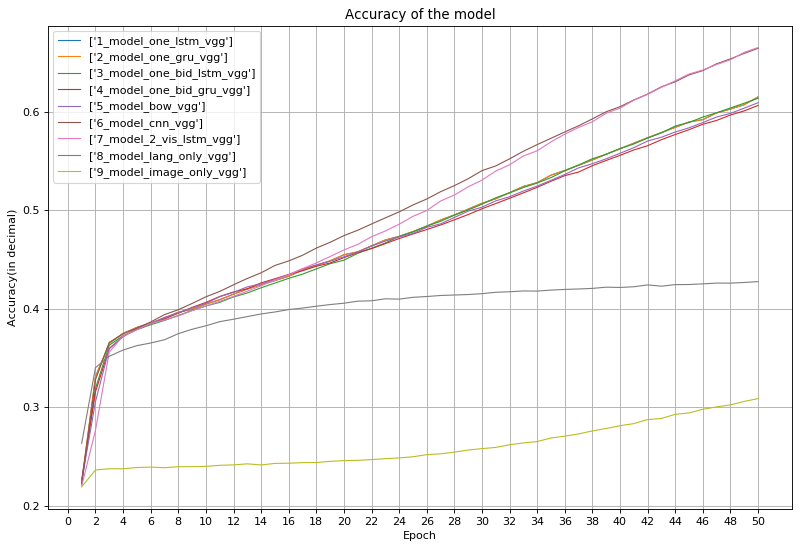

In [15]:
figure(num=None, figsize=(12, 8), dpi=80)
accuracy = []
name = []
axes= plt.axes()
axes.grid()
axes.set_title('Accuracy of the model')
axes.set_xlabel("Epoch")
axes.set_ylabel("Accuracy(in decimal)")
for i in metric_files:
    metric = pd.read_csv(i)
    accuracy = metric["accuracy"]
    name.append(list(set(metric["models"])) )
    epochs = np.arange(1, 51, 1)
    line1, = plt.plot(epochs, accuracy, linewidth = 1)
    plt.xticks(np.arange(0, 51, 2))
    plt.yticks(np.arange(0.2, 0.7, 0.1))
plt.gca().legend(name)
plt.show()

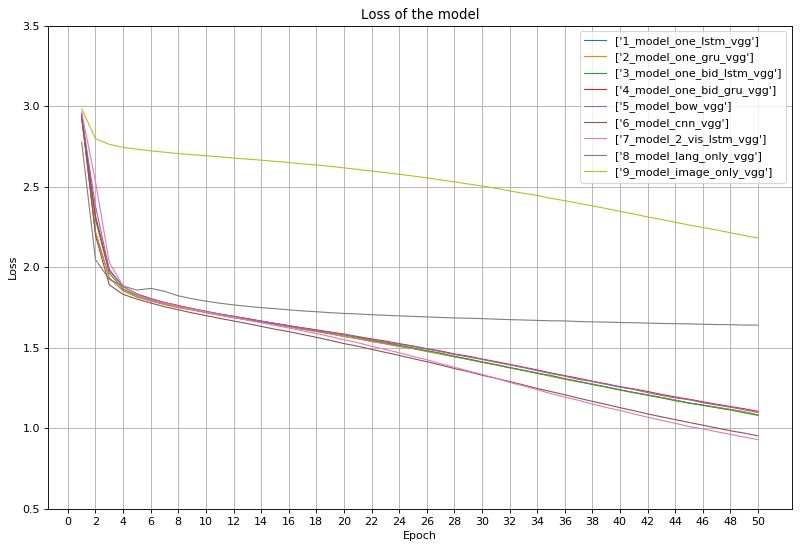

In [14]:
figure(num=None, figsize=(12, 8), dpi=80)
loss = []
name = []
axes= plt.axes()
axes.grid()
axes.set_title('Loss of the model')
axes.set_xlabel("Epoch")
axes.set_ylabel("Loss")
for i in metric_files:
    metric = pd.read_csv(i)
    accuracy = metric["loss"]
    name.append(list(set(metric["models"])) )
    epochs = np.arange(1, 51, 1)
    line1, = plt.plot(epochs, accuracy, linewidth = 1)
    plt.xticks(np.arange(0, 51, 2))
    plt.yticks(np.arange(0.5, 4, 0.5))
plt.gca().legend(name)
plt.show()

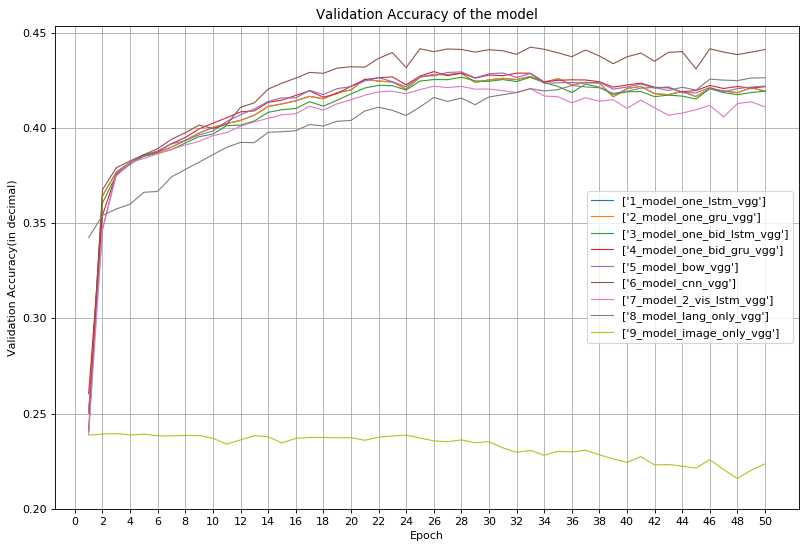

In [12]:
figure(num=None, figsize=(12, 8), dpi=80)
validation_accuracy = []
name = []
axes= plt.axes()
axes.grid()
axes.set_title('Validation Accuracy of the model')
axes.set_xlabel("Epoch")
axes.set_ylabel("Validation Accuracy(in decimal)")
for i in metric_files:
    metric = pd.read_csv(i)
    accuracy = metric["validation_accuracy"]
    name.append(list(set(metric["models"])) )
    epochs = np.arange(1, 51, 1)
    line1, = plt.plot(epochs, accuracy, linewidth = 1)
    plt.xticks(np.arange(0, 51, 2))
    plt.yticks(np.arange(0.2, 0.5, 0.05))
plt.gca().legend(name)
plt.show()

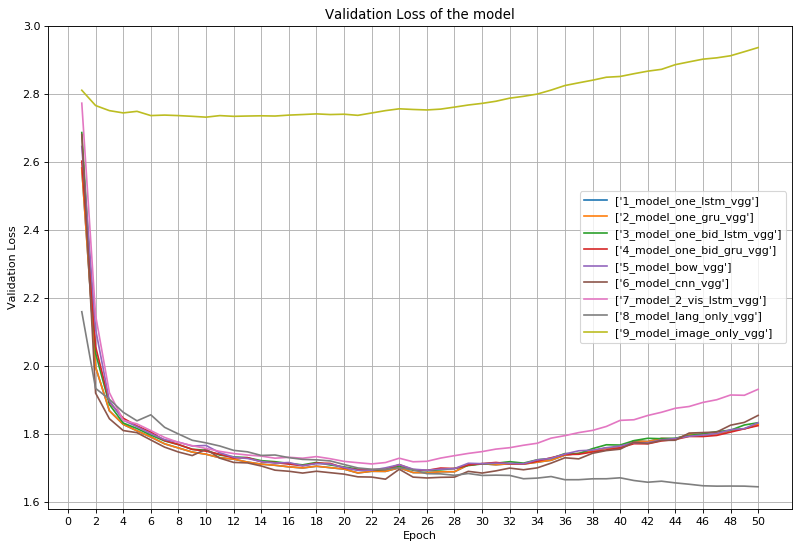

In [3]:
figure(num=None, figsize=(12, 8), dpi=80)
validation_loss = []
name = []
axes= plt.axes()
axes.grid()
axes.set_title('Validation Loss of the model')
axes.set_xlabel("Epoch")
axes.set_ylabel("Validation Loss")
for i in metric_files:
    metric = pd.read_csv(i)
    accuracy = metric["validation_loss"]
    name.append(list(set(metric["models"])) )
    epochs = np.arange(1, 51, 1)
    line1, = plt.plot(epochs, accuracy, linewidth = 1.5)
    plt.xticks(np.arange(0, 51, 2))
    #plt.yticks(np.arange(0.15, 0.45, 0.05))
plt.gca().legend(name)
plt.show()

Selecting the model which has lowest validation loss.